In [1]:
import findspark
findspark.init("/usr/local/spark")

from pyspark.sql import SparkSession
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

In [2]:
df = (spark.read.format("csv").options(header="true").option("inferschema","true")
    .load("./rental_crime/content.csv"))
# file:///usr/local/spark/README.md



In [46]:
# df.show(10)
df.describe('crime_score')

DataFrame[summary: string, crime_score: string]

In [16]:
# df.show()
# df.select(['Zipcode','Year','Month','Primary Type','crime_score','RentalPrice']).show(10)
sdf = df.groupBy(['Zipcode','Year-Month','Year','Month','crime_score','RentalPrice']).count().sort(['Year-Month','Zipcode'], ascending=True)
# sdf.show()
from pyspark.sql.functions import to_timestamp
sdf = sdf.withColumn("Timestamp", to_timestamp("Year-Month", "yyyy-MM"))

sdf = sdf.drop('Year-Month')
# df.describe(columns[1:5]).show()

In [17]:
# sdf = sdf.drop('RentalPrice')
# sdf = sdf.drop('crime_score')
sdf = sdf.drop('count')

In [18]:
sdf.show()

+-------+----+-----+-----------+-----------+-------------------+
|Zipcode|Year|Month|crime_score|RentalPrice|          Timestamp|
+-------+----+-----+-----------+-----------+-------------------+
|  46327|2001|    1|   2.405761|       null|2001-01-01 00:00:00|
|  46394|2001|    1|  1.5918214|       null|2001-01-01 00:00:00|
|  60018|2001|    1|  12.613393|       null|2001-01-01 00:00:00|
|  60106|2001|    1|        0.0|       null|2001-01-01 00:00:00|
|  60171|2001|    1|        0.0|       null|2001-01-01 00:00:00|
|  60176|2001|    1|        0.0|       null|2001-01-01 00:00:00|
|  60302|2001|    1|  18.091293|       null|2001-01-01 00:00:00|
|  60304|2001|    1|  2.8516543|       null|2001-01-01 00:00:00|
|  60402|2001|    1| 0.08169401|       null|2001-01-01 00:00:00|
|  60406|2001|    1|        0.0|       null|2001-01-01 00:00:00|
|  60419|2001|    1|  3.1703038|       null|2001-01-01 00:00:00|
|  60456|2001|    1|  5.3868523|       null|2001-01-01 00:00:00|
|  60459|2001|    1|  6.1

In [19]:
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType

dateToInt = udf(lambda year, month : (year-2001)*12 + month, IntegerType())
sdf = sdf.withColumn("date", dateToInt(col('Year'), col('Month')))

In [45]:
panda_sdf = sdf.toPandas()


In [75]:
import matplotlib.pyplot as plt
import pandas as pd

filtered_sdf = panda_sdf[panda_sdf['Zipcode']==60619]
#print(filtered_sdf.head())
mask = (filtered_sdf['Timestamp'] > '2007-01-01') & (filtered_sdf['Timestamp'] <= '2009-05-01')
filtered_sdf = filtered_sdf[mask]


In [76]:
print(filtered_sdf.head())

      Zipcode  Year  Month  crime_score  Timestamp  date
5634    60619  2007      2    423.99014 2007-02-01    74
5710    60619  2007      3    411.79245 2007-03-01    75
5787    60619  2007      4    460.62137 2007-04-01    76
5865    60619  2007      5    445.13318 2007-05-01    77
5941    60619  2007      6    530.06100 2007-06-01    78


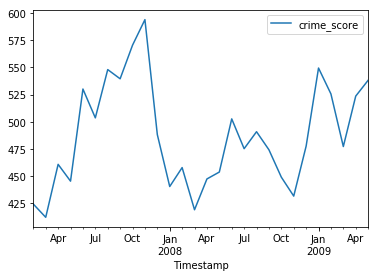

In [77]:
filtered_sdf.plot(x='Timestamp', y='crime_score')
# plt.scatter(filtered_sdf['Timestamp'], filtered_sdf['crime_score'])
plt.show()

In [46]:
import pandas as pd
# try filtering and plotting on a regression
# filtered_sdf = sdf.filter(sdf.Zipcode == '60603')
one_hot = pd.get_dummies(panda_sdf['Zipcode'],prefix="zipcode")
# Drop column B as it is now encoded
panda_sdf = panda_sdf.drop('Zipcode',axis = 1)
# Join the encoded df
panda_sdf = panda_sdf.join(one_hot)


In [47]:
panda_sdf = panda_sdf.drop(['Year','Month'],axis = 1)

In [48]:
print(panda_sdf.head())

   crime_score  RentalPrice  Timestamp  date  zipcode_46327  zipcode_46394  \
0     2.405761          NaN 2001-01-01     1              1              0   
1     1.591821          NaN 2001-01-01     1              0              1   
2    12.613393          NaN 2001-01-01     1              0              0   
3     0.000000          NaN 2001-01-01     1              0              0   
4     0.000000          NaN 2001-01-01     1              0              0   

   zipcode_60018  zipcode_60068  zipcode_60106  zipcode_60131  ...  \
0              0              0              0              0  ...   
1              0              0              0              0  ...   
2              1              0              0              0  ...   
3              0              0              1              0  ...   
4              0              0              0              0  ...   

   zipcode_60660  zipcode_60661  zipcode_60707  zipcode_60712  zipcode_60714  \
0              0              

In [25]:
panda_sdf.shape
print(panda_sdf['RentalPrice'].shape)
# print(panda_sdf['crime_score'].shape)

(16859,)


In [28]:
# for crime prediction
X_input = panda_sdf.iloc[:,3:86]
X_train = X_input.iloc[:8000,:]
X_test = X_input.iloc[8000:,:]
y_train = panda_sdf['crime_score'].iloc[:8000]
y_test = panda_sdf['crime_score'].iloc[8000:]

In [50]:
# for rental prediction
rental_sdf = panda_sdf.dropna()
print(rental_sdf.head())
print(rental_sdf.shape)
X_input = panda_sdf.iloc[:,3:86]
X_train = X_input.iloc[:3500,:]
X_test = X_input.iloc[3500:,:]
panda_sdf['RentalPrice'] = panda_sdf['RentalPrice'].fillna(0)
y_train = panda_sdf['RentalPrice'].iloc[:3500]
y_test = panda_sdf['RentalPrice'].iloc[3500:]

      crime_score  RentalPrice  Timestamp  date  zipcode_46327  zipcode_46394  \
9261     2.502496       1797.0 2011-01-01   121              0              0   
9265    27.408127       2026.0 2011-01-01   121              0              0   
9267    64.088070       1946.0 2011-01-01   121              0              0   
9268   120.754140       1526.0 2011-01-01   121              0              0   
9269   189.150740       1343.0 2011-01-01   121              0              0   

      zipcode_60018  zipcode_60068  zipcode_60106  zipcode_60131  ...  \
9261              0              0              0              0  ...   
9265              0              0              0              0  ...   
9267              0              0              0              0  ...   
9268              0              0              0              0  ...   
9269              0              0              0              0  ...   

      zipcode_60660  zipcode_60661  zipcode_60707  zipcode_60712  \
9261  

In [51]:
print(X_test.head())
print(y_test.head())

      date  zipcode_46327  zipcode_46394  zipcode_60018  zipcode_60068  \
3500    46              0              0              0              0   
3501    46              0              0              0              0   
3502    46              0              0              0              0   
3503    46              0              0              0              0   
3504    46              0              0              0              0   

      zipcode_60106  zipcode_60131  zipcode_60171  zipcode_60176  \
3500              0              0              0              0   
3501              0              0              0              0   
3502              0              0              0              0   
3503              0              0              0              0   
3504              0              0              0              0   

      zipcode_60202  ...  zipcode_60660  zipcode_60661  zipcode_60707  \
3500              0  ...              0              0              0   


In [52]:
from sklearn import linear_model
lm = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
model = lm.fit(X_train,y_train)

In [53]:
from sklearn.metrics import mean_squared_error, r2_score
predictions = lm.predict(X_test)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, predictions))
print('Variance score: %.2f' % r2_score(y_test, predictions))
# print(lm.score(X_input,panda_sdf['crime_score']))

Mean squared error: 1425776.66
Variance score: -0.51


[-1.66394612e-01 -4.43415599e+01 -4.14583672e+01 -3.30492881e+01
 -4.22051326e+01 -4.60540777e+01 -4.50457264e+01 -4.55584669e+01
 -4.59865821e+01 -4.37694407e+01 -2.70996053e+01 -4.25475623e+01
 -4.48906517e+01 -4.56914870e+01 -4.42159032e+01 -3.82593457e+01
 -3.99747077e+01 -4.40437061e+01 -4.55846062e+01 -4.02838466e+01
  2.01518158e+01 -2.20044283e+01 -3.84156013e+01 -1.62660763e+01
 -2.85012527e+01  4.29084037e+01  1.20236626e+02  1.83817747e+02
  8.46610252e+01 -4.46204959e+01  1.69165558e+02  1.98845319e+01
  5.04630387e+01  9.45324906e+01  1.05073739e+02  2.50319241e+02
  8.06057752e+01  4.29184515e+02  3.41654277e+02  4.19447087e+02
  1.29984766e+02  2.17662582e+02  3.76303216e+02  7.60977875e+01
  8.72425493e+01  3.45648800e+02  3.13157254e+02  1.33521272e+01
 -3.46667386e+01  1.25502624e+02 -2.47531127e+01 -6.52917890e+00
  3.41397917e+02  3.18726324e+02  4.80475856e+01  2.52961007e+02
  7.26934013e+01  1.15841955e+02  5.06822200e+01  1.20642033e+02
  2.79428222e+02 -5.60332

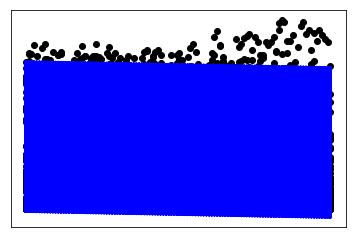

In [92]:
import matplotlib.pyplot as plt
print(lm.coef_)
print(lm.intercept_)

plt.scatter(X_test['date'], y_test,  color='black')
plt.plot(X_test['date'], predictions, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [53]:

# sdf.show()
# from pyspark_dist_explore import hist
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# hist(ax, sdf, bins = 20, color=['red'])

+-------+-----------+-----------+-----+-------------------+
|Zipcode|crime_score|RentalPrice|count|          Timestamp|
+-------+-----------+-----------+-----+-------------------+
|  46327|   2.405761|       null|   20|2001-01-01 00:00:00|
|  46394|  1.5918214|       null|   28|2001-01-01 00:00:00|
|  60018|  12.613393|       null|  151|2001-01-01 00:00:00|
|  60106|        0.0|       null|    1|2001-01-01 00:00:00|
|  60171|        0.0|       null|    2|2001-01-01 00:00:00|
|  60176|        0.0|       null|    1|2001-01-01 00:00:00|
|  60302|  18.091293|       null|  101|2001-01-01 00:00:00|
|  60304|  2.8516543|       null|   36|2001-01-01 00:00:00|
|  60402| 0.08169401|       null|   11|2001-01-01 00:00:00|
|  60406|        0.0|       null|    5|2001-01-01 00:00:00|
|  60419|  3.1703038|       null|   29|2001-01-01 00:00:00|
|  60456|  5.3868523|       null|   55|2001-01-01 00:00:00|
|  60459|  6.1480236|       null|   77|2001-01-01 00:00:00|
|  60501|  1.7295897|       null|   28|2

In [72]:
panda_sdf = sdf.toPandas()

# sdf.describe(['Timestamp','crime_score'])
# from matplotlib import pyplot
# panda_sdf.plot(kind='barh',x='Timestamp',y='crime_score')

In [86]:
import pandas as pd
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in d.items() })
# grouped_sdf = pd.DataFrame.from_dict(d, orient='index')
print(dict_df.head())

              2001-01             2001-02               2001-03  \
0   {46327: 2.405761}  {46327: 1.7813306}    {46327: 2.2542598}   
1  {46394: 1.5918214}  {46394: 1.9566742}     {46394: 2.205916}   
2  {60018: 12.613393}  {60018: 18.673098}    {60018: 20.448235}   
3        {60106: 0.0}        {60176: 0.0}  {60171: 0.008465393}   
4        {60171: 0.0}  {60302: 15.423354}          {60176: 0.0}   

                 2001-04                2001-05                2001-06  \
0     {46327: 1.8880568}     {46327: 2.0326161}     {46327: 1.6740212}   
1     {46394: 1.9370489}     {46394: 2.2095606}     {46394: 1.8189083}   
2     {60018: 19.523895}     {60018: 17.258432}     {60018: 16.796118}   
3  {60171: 0.0042326967}  {60171: 0.0021163484}  {60171: 0.0010581742}   
4           {60176: 0.0}           {60176: 0.0}           {60176: 0.0}   

              2001-07                2001-08                 2001-09  \
0  {46327: 2.0156004}     {46327: 1.4897541}      {46327: 1.4079517}   
1  {4639

In [67]:

print(panda_sdf.head())

one_hot = pd.get_dummies(panda_sdf['Zipcode'],prefix="zipcode")
# Drop column B as it is now encoded
panda_sdf = panda_sdf.drop('Zipcode',axis = 1)
# Join the encoded df
panda_sdf = panda_sdf.join(one_hot)
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index(['Date'], drop=True)
print(panda_sdf.head())

   Zipcode  crime_score  RentalPrice  count  Timestamp
0    46327     2.405761          0.0     20 2001-01-01
1    46394     1.591821          0.0     28 2001-01-01
2    60018    12.613393          0.0    151 2001-01-01
3    60106     0.000000          0.0      1 2001-01-01
4    60171     0.000000          0.0      2 2001-01-01
   crime_score  RentalPrice  count  Timestamp  zipcode_46327  zipcode_46394  \
0     2.405761          0.0     20 2001-01-01              1              0   
1     1.591821          0.0     28 2001-01-01              0              1   
2    12.613393          0.0    151 2001-01-01              0              0   
3     0.000000          0.0      1 2001-01-01              0              0   
4     0.000000          0.0      2 2001-01-01              0              0   

   zipcode_60018  zipcode_60068  zipcode_60106  zipcode_60131  ...  \
0              0              0              0              0  ...   
1              0              0              0         

In [68]:
panda_sdf = panda_sdf.drop(['RentalPrice'], axis=1, inplace=True)

In [50]:
# df.describe(["roomsPerHousehold","populationPerHousehold","bedroomsPerHousehold"]).show()
from pyspark.ml.linalg import DenseVector
# Define the `input_data` 
input_data = sdf.rdd.map(lambda x: (x[1], DenseVector([x[0],x[3],x[4]])))

# Replace `df` with the new DataFrame
modified_df = spark.createDataFrame(input_data, ["label", "features"])
modified_df.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 57.0 failed 1 times, most recent failure: Lost task 0.0 in stage 57.0 (TID 3937, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-50-54b841ae1a67>", line 4, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 280, in __init__
    ar = np.array(ar, dtype=np.float64)
TypeError: float() argument must be a string or a number, not 'datetime.datetime'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:409)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-50-54b841ae1a67>", line 4, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 280, in __init__
    ar = np.array(ar, dtype=np.float64)
TypeError: float() argument must be a string or a number, not 'datetime.datetime'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:409)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [31]:
# Import `StandardScaler` 
from pyspark.ml.feature import StandardScaler

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df)

# Transform the data in `df` with the scaler
scaled_df = scaler.transform(df)

# Inspect the result
scaled_df.take(2)

[Row(label=4.526, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.9841, 2.5556, 0.1466]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8228, 0.2461, 2.5264])),
 Row(label=3.585, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.2381, 2.1098, 0.1558]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.5213, 0.2031, 2.6851]))]

In [32]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)

# Import `LinearRegression`
from pyspark.ml.regression import LinearRegression

# Initialize `lr`
lr = LinearRegression(labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the data to the model
linearModel = lr.fit(train_data)

In [33]:
predicted = linearModel.transform(test_data)

# Extract the predictions and the "known" correct labels
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

# Zip `predictions` and `labels` into a list
predictionAndLabel = predictions.zip(labels).collect()
predictionAndLabel[:5]

[(1.1340115638008952, 0.14999),
 (1.4485018834650096, 0.14999),
 (1.5713396046425587, 0.14999),
 (1.7496542762527307, 0.283),
 (1.2438468929500472, 0.366)]

In [38]:
# Coefficients for the model
print(linearModel.coefficients)

# Intercept for the model
print(linearModel.intercept)

# Get the RMSE
print(linearModel.summary.rootMeanSquaredError)

# Get the R2
print(linearModel.summary.r2)

[0.0,0.0,0.0,0.2796215289269825,0.0,0.0,0.0]
0.9841344205626824
0.8765335684459216
0.42282227755911483


In [9]:
spark.stop()
